In [25]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

pd.set_option('display.max_columns', None)

Data cleaning

In [26]:
def label_encode(df, col):
    df[col] = df[col].fillna('nan')
    for val in sorted(df[col].unique()):
        df[f'{col}_{val}'] = df[col].apply(lambda x: 1 if x == val else 0)
    df = df.drop([col], axis=1)
    return df


def first_id_digit(x: str) -> int:
    if pd.isna(x) or x == 'nan' or type(x) != str:
        return x
    return int(x.split('_')[0][:1])


def encode_features(df):
    df = df.copy()

    df['first_digit'] = df.PassengerId.apply(lambda x: first_id_digit(x))
    df = label_encode(df, 'first_digit')

    # Label encode the last part of passenger id
    df['PassengerId_postfix'] = df.PassengerId.apply(lambda x: x.split('_')[1] if not pd.isna(x) else x)
    df = df.drop(['PassengerId'], axis=1)
    df = label_encode(df, 'PassengerId_postfix')

    # Label encode home planet
    df = label_encode(df, 'HomePlanet')

    # Label encode cryo sleep
    df['CryoSleep'] = df.CryoSleep.astype(str)
    df = label_encode(df, 'CryoSleep')

    # Label encode the first and last parts of cabin
    df['Cabin'] = df.Cabin.fillna('nan')
    df['Cabin_1'] = df.Cabin.apply(lambda x: x.split('/')[0] if '/' in x else x)
    df['Cabin_3'] = df.Cabin.apply(lambda x: x.split('/')[2] if '/' in x else x)
    df = df.drop(['Cabin'], axis=1)
    df = label_encode(df, 'Cabin_1')
    df = label_encode(df, 'Cabin_3')

    # Label encode destination
    df = label_encode(df, 'Destination')

    # Replace True and False with 1 and 0 (nan will be handled with imputation)
    df.VIP = df.VIP.apply(lambda x: int(x) if not pd.isna(x) else x)

    # Encode last letter of first name (may proxy gender)
    df['fname_end'] = df.Name.apply(lambda x: x.split(' ')[0][-1:] if not pd.isna(x) else x)
    df = label_encode(df, 'fname_end')

    # Encode last name uniqueness
    df.Name = df.Name.fillna('nan')
    df['LastName'] = df.Name.apply(lambda x: x.split(' ')[1] if not x == 'nan' else x)
    df['LastNameUnique'] = df.LastName.apply(lambda x: 1 if len(df[df.LastName == x]) <= 1 or x == 'nan' else 0)
    df = df.drop(['Name', 'LastName'], axis=1)

    return df


def impute_train(train_df):
    # Remove string placeholders for NAN values.
    for col in train_df:
        train_df[col] = train_df[col].apply(lambda x: np.nan if x == 'nan' else x)

    imputer = KNNImputer(n_neighbors=5).fit(train_df)
    train_df = pd.DataFrame(imputer.transform(train_df), columns=train_df.columns)

    return (train_df, imputer)


def impute_other(other_df: pd.DataFrame, imputer: KNNImputer) -> pd.DataFrame:
    return pd.DataFrame(imputer.transform(other_df), columns=other_df.columns)


def add_features(df):
    def spent_any(row):
        if (
            not pd.isna(row['RoomService']) and row['RoomService'] > 0 or
            not pd.isna(row['FoodCourt']) and row['FoodCourt'] > 0 or
            not pd.isna(row['ShoppingMall']) and row['ShoppingMall'] > 0 or
            not pd.isna(row['Spa']) and row['Spa'] > 0 or
            not pd.isna(row['VRDeck']) and row['VRDeck'] > 0                 				
        ):
            return True
        return False
    
    df['spent_any'] = df.apply(spent_any, axis=1)
    
    return df


RANDOM_SEED = 538

df = pd.read_csv('./train.csv')

train = df.sample(n=int(len(df) * .75), random_state=RANDOM_SEED)
valid = df[~df.index.isin(train.index)]

train = encode_features(train)
valid = encode_features(valid)

train, imputer = impute_train(train)
valid = impute_other(valid, imputer)

train = add_features(train)
valid = add_features(valid)

Modeling test

In [37]:
from sklearn.ensemble import RandomForestClassifier
from h2o.estimators.random_forest import H2ORandomForestEstimator
import h2o

train_plus_val = pd.read_csv('./train.csv')
train_plus_val = encode_features(train_plus_val)

X_train_plus_val = train_plus_val[[x for x in train_plus_val.columns if x != 'Transported']]
y_train_plus_val = train_plus_val['Transported']

X_train_plus_val, imputer = impute_train(X_train_plus_val)
X_train_plus_val = add_features(X_train_plus_val)
train_plus_val = pd.concat([X_train_plus_val, y_train_plus_val], axis=1)

test = pd.read_csv('./test.csv')
X_test = test.copy()
X_test = encode_features(X_test)
X_test = impute_other(X_test, imputer)
X_test = add_features(X_test)

rf = H2ORandomForestEstimator(
    max_depth=16,
    min_split_improvement=1e-07,
    min_rows=1,
    ntrees=100,
    stopping_metric='misclassification'
)

train_plus_val.to_csv('train_plus_val.csv', index=False)
h2o_train_plus_val = h2o.import_file('./train_plus_val.csv')

rf.train(
    [x for x in train_plus_val.columns if x != 'Transported'], 
    'Transported', 
    h2o_train_plus_val
)

binarize = lambda x: 1 if x > .5 else 0

X_test.to_csv('X_test.csv', index=False)
X_test = h2o.import_file('X_test.csv')

y_pred = rf.predict(X_test)

result = [binarize(x) for x in y_pred[:, 0].as_data_frame().to_numpy()]
with open('h20-pred.csv', 'w') as file:
    file.write(f'PassengerId,Transported\n')
    for val in result:
        file.write(str(val) + '\n')

C:\Users\jackv\AppData\Local\Temp\ipykernel_19228\3583604400.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col] = train_df[col].apply(lambda x: np.nan if x == 'nan' else x)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |

c:\Users\jackv\anaconda3\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: Stopping metric is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\jackv\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Visualization

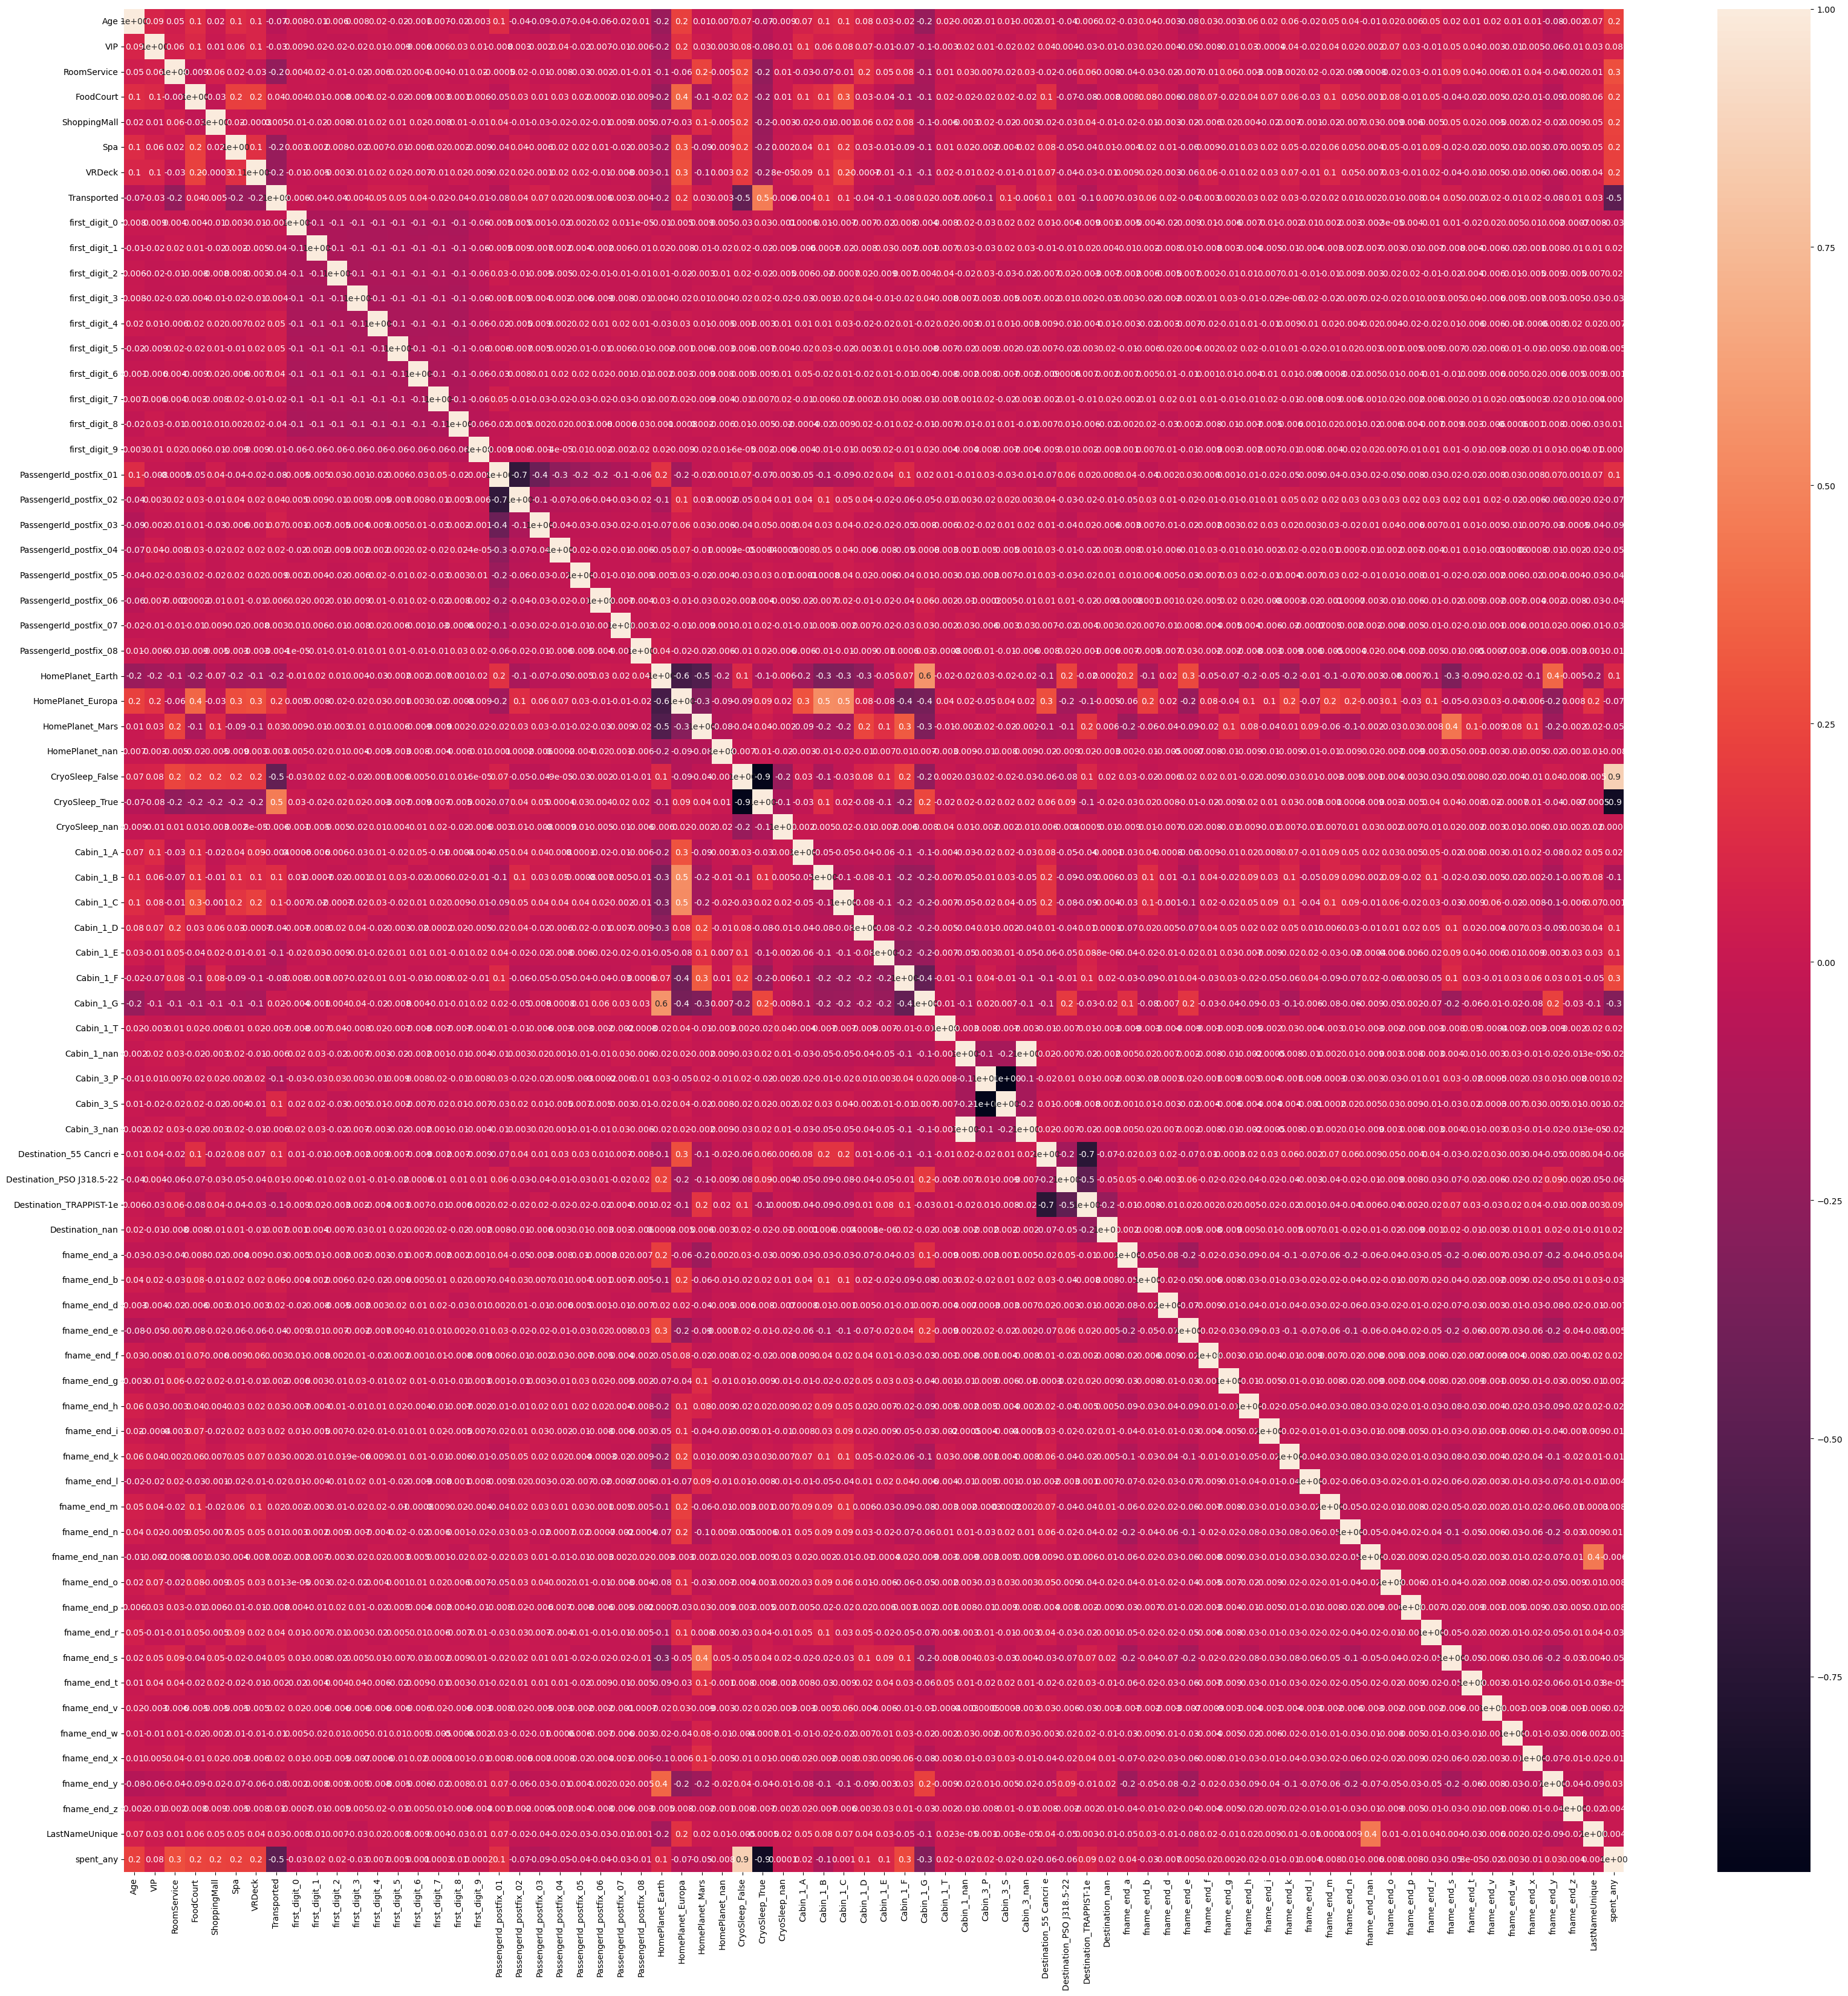

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))
sns.heatmap(train.corr(), annot=True, fmt='.1')
plt.show()

Decision tree

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

results = []  # (accuracy, max_depth, min_samples_leaf, criterion)

# 'log_loss'
for criterion in ['gini', 'entropy']:
    for min_samples_leaf in range(1, 40)[::-1]:
        for max_depth in range(1, 20)[::-1]:
            model = DecisionTreeClassifier(
                max_depth=max_depth, 
                min_samples_leaf=min_samples_leaf, 
                criterion=criterion
            )

            X_train = train[[x for x in train.columns if 'Transported' not in x]]
            y_train = train[['Transported']]

            X_val = valid[[x for x in valid.columns if 'Transported' not in x]]
            y_val = valid[['Transported']]

            model.fit(X_train, y_train);
            y_pred = model.predict(X_val)
            results.append((accuracy_score(y_val, y_pred), max_depth, min_samples_leaf, criterion))


In [69]:
import matplotlib.pyplot as plt

rdf = pd.DataFrame(results, columns=['accuracy', 'max_depth', 'min_samples_leaf', 'criterion'])
display(rdf.sort_values('accuracy', ascending=False).head(10))



,accuracy,max_depth,min_samples_leaf,criterion
385,0.797148,14,29,gini
380,0.795308,19,29,gini
383,0.795308,16,29,gini
382,0.795308,17,29,gini
381,0.795308,18,29,gini
386,0.795308,13,29,gini
368,0.794388,12,30,gini
384,0.794388,15,29,gini
387,0.794388,12,29,gini
404,0.793928,14,28,gini


In [89]:
model = DecisionTreeClassifier(
                max_depth=15, 
                min_samples_leaf=30, 
                criterion='gini'
            )

X_train = train[[x for x in train.columns if 'Transported' not in x]]
y_train = train[['Transported']]

X_val = valid[[x for x in valid.columns if 'Transported' not in x]]
y_val = valid[['Transported']]

model.fit(X_train, y_train);
y_pred = model.predict(X_val)

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
unique_classes = np.unique(y_train)
class_names = ['Not Transported' if c == 0 else 'Transported' for c in unique_classes]

from sklearn.tree import export_graphviz

import graphviz

# Export as dot file
dot_data = export_graphviz(model, out_file=None, 
                           feature_names=list(X_train.columns),  
                           class_names=class_names,
                           filled=True, rounded=True,  
                           special_characters=True)

# Use graphviz to render the dot data to a PDF
graph = graphviz.Source(dot_data)
graph.render("decision_tree", format="pdf")  # Saves the tree to a PDF file named "decision_tree.pdf"

  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)


'decision_tree.pdf'

In [107]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Set the style of the seaborn
# sns.set(style="whitegrid")

# # Create a figure to hold the plots
# plt.figure(figsize=(20, 100))

# plotdf = train[[x for x in train.columns if x != 'Transported']]

# # Get the number of features (exclude target variable if it's included in df)
# num_features = plotdf.shape[1]  # Adjust this if you need to exclude the target variable

# # Loop through each feature to create a boxplot
# for i, column in enumerate(plotdf.columns, 1):
#     plt.subplot((num_features + 1) // 2, 2, i)  # Adjust the grid size as necessary
#     sns.boxplot(y=plotdf[column])
#     plt.title(f'Box plot of {column}', fontsize=10)
#     plt.xlabel('')
#     plt.ylabel('')

# # Adjust layout for better fit and show the plots
# plt.tight_layout()
# plt.show()


K Nearest Neighbors

In [105]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

knn_results = []  # (accuracy, k, distance)

X_train = np.array(train[[x for x in train.columns if 'Transported' not in x]])
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
y_train = train[['Transported']].values.ravel()

X_val = np.array(valid[[x for x in valid.columns if 'Transported' not in x]])
X_val = scaler.transform(X_val)
y_val = valid[['Transported']].values.ravel()

for distance in ['manhattan', 'euclidean']:
    for k in range(1, 75)[::-1]:
        model = KNeighborsClassifier(
            n_neighbors=k,
            metric=distance
        )

        model.fit(X_train, y_train);
        y_pred = model.predict(X_val)
        knn_results.append((accuracy_score(y_val, y_pred), k, distance))


In [106]:
knn_df = pd.DataFrame(knn_results, columns=['accuracy', 'k', 'distance'])
knn_df.sort_values('accuracy', ascending=False).head(10)

,accuracy,k,distance
41,0.776449,58,manhattan
71,0.775989,28,manhattan
53,0.775989,46,manhattan
55,0.775989,44,manhattan
60,0.774609,39,manhattan
43,0.774609,56,manhattan
54,0.774609,45,manhattan
59,0.774609,40,manhattan
56,0.774149,43,manhattan
52,0.774149,47,manhattan


Logistic regression

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

log_results = []  # (accuracy, c, penalty, solver)

X_train = np.array(train[[x for x in train.columns if 'Transported' not in x]])
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
y_train = train[['Transported']].values.ravel()

X_val = np.array(valid[[x for x in valid.columns if 'Transported' not in x]])
X_val = scaler.transform(X_val)
y_val = valid[['Transported']].values.ravel()

for solver in ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']:
    for penalty in ['l1', 'l2', 'elasticnet']:
        for cval in np.linspace(0.0001, 1000, 30):
            if solver in ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'] and penalty != 'l2':
                continue

            if solver != 'saga' and penalty == 'elasticnet':
                continue

            l1_ratio = None
            if penalty == 'elasticnet':
                l1_ratio = .5

            model = LogisticRegression(
                C=cval,
                penalty=penalty,
                solver=solver,
                random_state=RANDOM_SEED,
                max_iter=1000,
                l1_ratio=l1_ratio
            )

            model.fit(X_train, y_train);
            y_pred = model.predict(X_val)
            log_results.append((accuracy_score(y_val, y_pred), cval, penalty, solver))


In [126]:
log_df = pd.DataFrame(log_results, columns=['accuracy', 'c', 'penalty', 'solver'])
log_df.sort_values('accuracy', ascending=False).head(10)

,accuracy,c,penalty,solver
135,0.792088,517.241428,l2,newton-cholesky
184,0.792088,137.931121,l1,saga
169,0.792088,655.172448,l2,sag
170,0.792088,689.655203,l2,sag
171,0.792088,724.137959,l2,sag
172,0.792088,758.620714,l2,sag
173,0.792088,793.103469,l2,sag
174,0.792088,827.586224,l2,sag
175,0.792088,862.068979,l2,sag
176,0.792088,896.551734,l2,sag


Scikit Learn Random forest

In [145]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_results = []  # (accuracy, )

X_train = train[[x for x in train.columns if 'Transported' not in x]]
y_train = train[['Transported']].values.ravel()

X_val = valid[[x for x in valid.columns if 'Transported' not in x]]
y_val = valid[['Transported']].values.ravel()

# 'log_loss', 'gini'
for criterion in ['entropy']:
    for min_samples_leaf in [int(x) for x in np.linspace(1, 25, 15)]:
        for max_depth in [int(x) for x in np.linspace(3, 75, 15)]:

            N_ESTIMATORS = 100

            model = RandomForestClassifier(
                n_estimators=N_ESTIMATORS,
                max_depth=max_depth,
                criterion=criterion,
                min_samples_leaf=min_samples_leaf,
                random_state=RANDOM_SEED
            )

            model.fit(X_train, y_train);
            y_pred = model.predict(X_val)
            rf_results.append((accuracy_score(y_val, y_pred), N_ESTIMATORS, max_depth, criterion, min_samples_leaf))


In [141]:
rf_df = pd.DataFrame(rf_results, columns=['accuracy', 'N_ESTIMATORS', 'max_depth', 'criterion', 'min_samples_leaf'])
rf_df.sort_values('accuracy', ascending=False).head(10)

,accuracy,N_ESTIMATORS,max_depth,criterion,min_samples_leaf
18,0.802668,50,18,entropy,2
33,0.802668,50,18,entropy,4
49,0.802668,50,23,entropy,6
47,0.802208,50,13,entropy,6
44,0.801748,50,75,entropy,4
43,0.801748,50,69,entropy,4
42,0.801748,50,64,entropy,4
41,0.801748,50,59,entropy,4
40,0.801748,50,54,entropy,4
39,0.801748,50,49,entropy,4


h2o Random Forest

In [15]:
!pip install h2o

     ---------------------------------------- 0.0/265.2 MB ? eta -:--:--
     ---------------------------------------- 0.1/265.2 MB 2.6 MB/s eta 0:01:44
     ---------------------------------------- 0.2/265.2 MB 3.4 MB/s eta 0:01:18
     ---------------------------------------- 0.8/265.2 MB 7.2 MB/s eta 0:00:37
     --------------------------------------- 2.1/265.2 MB 12.0 MB/s eta 0:00:22
      -------------------------------------- 3.5/265.2 MB 15.9 MB/s eta 0:00:17
      -------------------------------------- 5.0/265.2 MB 18.7 MB/s eta 0:00:14
      -------------------------------------- 6.7/265.2 MB 20.5 MB/s eta 0:00:13
     - ------------------------------------- 7.6/265.2 MB 21.1 MB/s eta 0:00:13
     - ------------------------------------- 8.7/265.2 MB 23.2 MB/s eta 0:00:12
     - ------------------------------------ 10.3/265.2 MB 23.4 MB/s eta 0:00:11
     - ------------------------------------ 12.2/265.2 MB 31.2 MB/s eta 0:00:09
     - ------------------------------------ 13.

In [3]:
train.to_csv('./h2o-train.csv', index=False)
valid.to_csv('./h2o-valid.csv', index=False)

In [4]:
import h2o

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.18+9-LTS-195, mixed mode)
  Starting server from C:\Users\jackv\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\jackv\AppData\Local\Temp\tmppbwevt99
  JVM stdout: C:\Users\jackv\AppData\Local\Temp\tmppbwevt99\h2o_Jack_Vandeleuv_started_from_python.out
  JVM stderr: C:\Users\jackv\AppData\Local\Temp\tmppbwevt99\h2o_Jack_Vandeleuv_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 14 days
H2O_cluster_name:,H2O_from_python_Jack_Vandeleuv_w3iqwl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.934 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [5]:
h2o_train = h2o.import_file('./h2o-train.csv')
h2o_valid = h2o.import_file('./h2o-valid.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
from sklearn.metrics import accuracy_score
from h2o.grid.grid_search import H2OGridSearch

X = [x for x in h2o_train.columns if x != 'Transported']
y = 'Transported'

h2o_train[y] = h2o_train[y].asfactor()
h2o_valid[y] = h2o_valid[y].asfactor()


rf_params = {
    'max_depth': [int(x) for x in np.linspace(5, 50, 5)],
    'min_split_improvement': [x for x in np.linspace(1e-07, 1e-03, 5)],
    'min_rows': [int(x) for x in np.linspace(1, 20, 5)],
    'ntrees': [100],
    'stopping_metric': 'misclassification'
}

grid = H2OGridSearch(
    model=H2ORandomForestEstimator,
    grid_id='rf_grid5',
    hyper_params=rf_params
)

grid.train(
    x=X, 
    y=y,
    training_frame=h2o_train,
    validation_frame=h2o_valid,
    seed=RANDOM_SEED
)

# h2o_rf.train(x=features, y='Transported', training_frame=h2o_train)
# y_pred = h2o_rf.predict(h2o_valid[[x for x in h2o_valid.columns if x != 'Transported']])

# print(type(y_pred))
# accuracy_score(h2o_valid['Transported'].as_data_frame().to_numpy(), y_pred.as_data_frame().to_numpy())

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,max_depth,min_rows,min_split_improvement,ntrees,stopping_metric,model_ids,logloss
,16.0,1.0,1e-07,100.0,misclassification,rf_grid5_model_2,0.4069010
,16.0,1.0,0.0005000,100.0,misclassification,rf_grid5_model_52,0.4069530
,16.0,1.0,0.0002501,100.0,misclassification,rf_grid5_model_27,0.4073033
,16.0,1.0,0.0007500,100.0,misclassification,rf_grid5_model_77,0.4075163
,16.0,1.0,0.001,100.0,misclassification,rf_grid5_model_102,0.4085201
,38.0,5.0,0.0002501,100.0,misclassification,rf_grid5_model_34,0.4105855
,50.0,5.0,0.0002501,100.0,misclassification,rf_grid5_model_35,0.4105855
,27.0,5.0,0.0002501,100.0,misclassification,rf_grid5_model_33,0.4106022
,38.0,5.0,0.0005000,100.0,misclassification,rf_grid5_model_59,0.4108609
,50.0,5.0,0.0005000,100.0,misclassification,rf_grid5_model_60,0.4108609


In [7]:
best_model = grid.get_grid(sort_by='accuracy', decreasing=True).models[0]
y_pred = best_model.predict(h2o_valid[[x for x in h2o_valid.columns if x != 'Transported']])

binarize = lambda x: 1 if x > .5 else 0

accuracy_score(
    h2o_valid['Transported'].as_data_frame().to_numpy(),
    y_pred.as_data_frame().to_numpy()[:, 0]
)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\jackv\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\jackv\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


0.8160073597056118

In [8]:
best_model.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,Age,10111.592773,1.000000,0.100287
1,spent_any,8347.988281,0.825586,0.082796
2,Spa,7491.260254,0.740859,0.074299
3,VRDeck,6247.467773,0.617852,0.061963
4,CryoSleep_False,6246.288086,0.617735,0.061951
...,...,...,...,...
68,fname_end_f,59.422691,0.005877,0.000589
69,fname_end_g,56.448830,0.005583,0.000560
70,PassengerId_postfix_08,44.567699,0.004408,0.000442
71,Cabin_1_T,4.799154,0.000475,0.000048


In [24]:
result = [binarize(x) for x in y_pred[:, 0].as_data_frame().to_numpy()]
with open('h20-pred.csv', 'w') as file:
    for val in result:
        file.write(str(val) + '\n')

c:\Users\jackv\anaconda3\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
